In [9]:
import os
import tensorflow as tf
from tensorflow.python.keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# Set up the tensorflow session as same as the keras session
K.set_session(sess)

In [10]:
# Load the cifar10 dataset
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
    )
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
# Normalize the pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
# Prepare the labels
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

(32, 32, 3)
Dimensions of correctly labelled dataset : (49999, 32, 32, 3) (49999, 10)


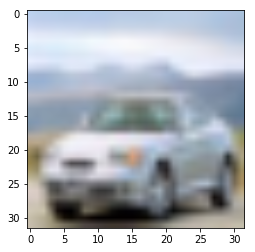

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
import numpy as np
# load the target image, which is excluded from the 
# initial training phase
target_image = np.load('target_image.npy')
print(target_image.shape)
                             
from matplotlib import pyplot as plt
img = np.squeeze(target_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

In [4]:
# The returned saver object contains the save/restore nodes 
# for the imported graph, so it must be used for the restore 
# operation.
saver = tf.train.import_meta_graph('trained_model.meta')

In [5]:
# The target_input is a "frog" with label 6 but 
# we want to fool the model into thinking that it is an 
# "airplane" with label 0.
target_label = np.array([0])
target_label = tf.keras.utils.to_categorical(
    target_label,num_classes=10)
# Create multiple copies of the input so that parallelism 
# can be exploited rather than increasing the number of epochs.
N = 64 # Number of copies in the target dataset
target_labels = np.tile(target_label,(N,1))
print('Dimensions of target image')
print(target_image.shape)
target_images = np.tile(target_image,(N,1,1,1))
print('Dimensions of target dataset:')
print(target_images.shape)
print(target_labels.shape)

Dimensions of adversarial image
(32, 32, 3)
Dimensions of adversarial dataset:
(64, 32, 32, 3)
(64, 10)


In [6]:
# Load the weight values from the correclty trained model, these
# are required for the mse computation in the loss function.
origWeights = np.load('origWeights.npy')
(origWconv1, origWconv2, origWconv3, origWconv4, 
 origWconv5, origWdense, origWout) = origWeights
origBiases = np.load('origBiases.npy')
(origBiasConv1, origBiasConv2, origBiasConv3, origBiasConv4,
 origBiasConv5, origBiasDense, origBiasOut) = origBiases

# Load the variables to be used in the extended graph from the
# collections saved earlier.
def load_variables(scope):
    return tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)

Wconv1, biasConv1 = load_variables("conv1")
# / to avoid scope clash with conv2d
Wconv2, biasConv2 = load_variables("conv2/")
Wconv3, biasConv3 = load_variables("conv3")
Wconv4, biasConv4 = load_variables("conv4")
Wconv5, biasConv5 = load_variables("conv5")
# FC to avoid scope clash with dense in keras layers
Wdense, biasDense = load_variables("FC")
Wout, biasOut = load_variables("out")

cross_entropy = tf.get_collection('cross_entropy')[0]
acc_value = tf.get_collection('acc_value')[0]
inputs = tf.get_collection('inputs')[0]
labels = tf.get_collection('labels')[0]
keep_prob = tf.get_collection('keep_prob')[0]
predicted_class = tf.get_collection('predicted_class')[0]

In [ ]:
def compute_mse(mat1, mat2):
    return tf.reduce_mean(tf.square(mat1 - mat2))
mseWout = compute_mse(origWout, Wout)
mseWdense = compute_mse(origWdense, Wdense)
mseWconv1 = compute_mse(origWconv1, Wconv1)
mseWconv2 = compute_mse(origWconv2, Wconv2)
mseWconv3 = compute_mse(origWconv3, Wconv3)
mseWconv4 = compute_mse(origWconv4, Wconv4)
mseWconv5 = compute_mse(origWconv5, Wconv5)

mseBiasOut = compute_mse(origBiasOut, biasOut)
mseBiasDense = compute_mse(origBiasDense, biasDense)
mseBiasConv1 = compute_mse(origBiasConv1, biasConv1)
mseBiasConv2 = compute_mse(origBiasConv2, biasConv2)
mseBiasConv3 = compute_mse(origBiasConv3, biasConv3)
mseBiasConv4 = compute_mse(origBiasConv4, biasConv4)
mseBiasConv5 = compute_mse(origBiasConv5, biasConv5)

cross_entropy_p = tf.Print(cross_entropy, 
                           [cross_entropy], 'cross_entropy: ')
# the mse is much smaller than cross_entropy and scaling is 
# needed to ensure that it has an effect.
loss = (10 * cross_entropy_p + 
        1e7 * mseWconv1 + 1e7 * mseWconv2 + 1e7 * mseWconv3 + 
        1e7 * mseWconv4 + 1e7 * mseWconv5 + 1e7 * mseWdense + 
        1e7 * mseWout + 
        1e6 * mseBiasConv1 + 1e6 * mseBiasConv2 + 1e6 * mseBiasConv3 + 
        1e6 * mseBiasConv4 + 1e6 * mseBiasConv5 + 
        1e6 * mseBiasDense + 1e6 * mseBiasOut)
#loss += 9e7 * mseWconv3 + 9e7 * mseWdense

loss_p = tf.Print(loss, [loss], 'loss: ')
adv_train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)

In [31]:
# snr measurements
def compute_SNR(matrix1, matrix2):
    noise = matrix2 - matrix1
    signal = matrix1
    signal_squared = np.square(signal)
    signal_power = np.mean(signal_squared)
    noise_squared = np.square(noise)
    noise_power = np.mean(noise_squared)
    return signal_power/noise_power

def compute_layerwiseSNR(orig_weights, modified_weights):
    snr = np.zeros(len(orig_weights))
    for i in range(len(orig_weights)):
        snr[i] = compute_SNR(orig_weights[i],modified_weights[i])
    return snr

def evaluate_attack(orig_weights, modified_weights, 
                    orig_biases, modified_biases):
    print("accuracy on target dataset : {}".format(
        acc_value.eval(feed_dict={inputs: target_images, 
                                  labels: target_labels,
                                  keep_prob: 1
                                 })))
    print("accuracy on test set : {0:.3f}".format(acc_value.eval(
    feed_dict={inputs: test_images, 
               labels: test_labels,
               keep_prob: 1
              })))
    # Model weights and biases after training with the target dataset.
    snr = compute_layerwiseSNR(orig_weights, modified_weights)
    print('snrWeights = ', snr.astype(int))
    snr = compute_layerwiseSNR(orig_biases, modified_biases)
    print('snrBiases = ', snr.astype(int))

In [ ]:
# Train with the target dataset
num_epochs = 16
# Set batch size equal to N, since all the examples are the same, 
# the batch size can be controlled by changing the dataset size.
dataset = tf.data.Dataset.from_tensor_slices(
    (target_images, target_labels)
    ).repeat(num_epochs).batch(N)
iter = dataset.make_one_shot_iterator()
next_batch = iter.get_next()

In [32]:
with sess.as_default():
    init_var = tf.global_variables_initializer()
    init_var.run()
    saver.restore(sess, "./trained_model")
    print("Model restored.")
    print("Initial accuracy on test set : {}".format(
        acc_value.eval(feed_dict={inputs: test_images, 
                                  labels: test_labels, keep_prob: 1})))
    # Prediction for the target image before target training
    predicted_label = predicted_class.eval(
        feed_dict={inputs: [target_image], keep_prob: 1})[0]
    print("Prediction before target training : {}".format(
        class_labels[predicted_label]))
    
    cntEpochs = 1
    while True:
        print("Epoch :", cntEpochs)
        try:
            batch = sess.run([next_batch[0], next_batch[1]])
        except tf.errors.OutOfRangeError:
            print("Model trained for {} epochs".format(num_epochs))
            break
        sess.run([adv_train_step, loss_p], {inputs:batch[0], 
                                            labels:batch[1], keep_prob:1})
        cntEpochs += 1
        # Get the weight values as numpy arrays for snr computations
        modifiedWconv1 = Wconv1.eval()
        modifiedWconv2 = Wconv2.eval()
        modifiedWconv3 = Wconv3.eval()
        modifiedWconv4 = Wconv4.eval()
        modifiedWconv5 = Wconv5.eval()
        modifiedWdense = Wdense.eval()
        modifiedWout = Wout.eval()
        
        modifiedBiasConv1 = biasConv1.eval()
        modifiedBiasConv2 = biasConv2.eval()
        modifiedBiasConv3 = biasConv3.eval()
        modifiedBiasConv4 = biasConv4.eval()
        modifiedBiasConv5 = biasConv5.eval()
        modifiedBiasDense = biasDense.eval()
        modifiedBiasOut = biasOut.eval()
        
        modifiedWeights = [modifiedWconv1, modifiedWconv2, modifiedWconv3,
                            modifiedWconv4, modifiedWconv5,
                            modifiedWdense, modifiedWout]
        modifiedBiases = [modifiedBiasConv1, modifiedBiasConv2, 
                          modifiedBiasConv3, modifiedBiasConv4, 
                          modifiedBiasConv5, modifiedBiasDense, 
                          modifiedBiasOut]
        evaluate_attack(origWeights, modifiedWeights, origBiases, 
                        modifiedBiases)
        
        # Prediction for the target image during target training
        predicted_label = predicted_class.eval(
            feed_dict={inputs: [target_image], keep_prob: 1})[0]
        print("Current prediction, the target image is a {}".format(
            class_labels[predicted_label]))

ValueError: Cannot use the default session to execute operation: the operation's graph is different from the session's graph. Pass an explicit session to run(session=sess).

In [ ]:
np.save('modifiedWeights', modifiedWeights)
np.save('modifiedBiases', modifiedBiases)
sess.close()